# Imports

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from time import time
import sys

%load_ext autoreload
%autoreload 2

#%load_ext line_profiler
#%load_ext memory_profiler

from lightcone_functions import read_1LCSlice, read_1_LC, read_1_param, shrink_2D, shrink_1D, shrink_3D, read_N_LC,read_1_LC_2, LOAD_DATA

### 3D convolution, with variating kernel for each slice
from scipy.ndimage.filters import gaussian_filter

### LC color from Brad and Andrei
EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('EoR_colour', 
                                                                 [(0, 'white'),
                                                                  (0.21, 'yellow'),
                                                                  (0.42, 'orange'),
                                                                  (0.63, 'red'),
                                                                  (0.86, 'black'),
                                                                  (0.9, 'blue'),
                                                                  (1, 'cyan')])
plt.register_cmap(cmap=EoR_colour)
#plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams['image.cmap'] = 'EoR_colour'

In [4]:
def loadbar( i, Ntot, tin ):
    #titer = time() - t
    titerAvg = (time() - tin) / (i+1)
    sys.stdout.write('\r')
    sys.stdout.write( "[%-20s] %.1f%%"%('='*int((i+1)*100./Ntot/5),(i+1)*100./Ntot) )
    #sys.stdout.write( ", %.1f, %.1f s/iter, remain %.1f, %.1f s"%( titer, titerAvg, titer*(Ntot-i-1), titerAvg*(Ntot-i-1) ) )
    sys.stdout.write( ", %.1f s/iter, remain %.1f s, exec %.1f s"%( titerAvg, titerAvg*(Ntot-i-1), time()-tin ) )
    sys.stdout.flush()
    #return time()

# from time import sleep
# tin=time()
# for i in range(3):
#     sleep(1)
#     loadbar( i, 3, tin )

# loading test

In [ ]:
### load the last database : ICs=3
# (LC,LC_t),(P,P_t) = LOAD_DAT_old( dim=3, fullres=True, ICs=3, verbose=True, LHS=True )

### a quarter stencil of LC:
### size 150Mpc over 3300Mpc
### resolution 25 over 550 = a quarter of the initial resolution
DATABASE = '300Mpc_r200_2D' # '75Mpc_r50'
Nbins_LHS = 9000

(LC,LC_t),(P,P_t),(Praw,Praw_t) = LOAD_DATA( RandomSeed=2235, 
                                             trainSize=0.9, 
                                             LHS=True,
                                             verbose=True,
                                             Nbins_LHS=Nbins_LHS, 
                                             DATABASE=DATABASE,
                                             justParam=False )

#(LC,LC_t),(P,P_t),(Praw,Praw_t) = LOAD_DATA( verbose=True, LHS=True )

In [ ]:
### detect NAN
### few NAN can be in some LC
### this should be clean in the next LCDB
LC[ np.where( np.isnan(LC) ) ] = 0.
LC_t[ np.where( np.isnan(LC_t) ) ] = 0.

# verif plot

In [ ]:
num_LC_test = 201
LC_test = LC[num_LC_test,:,:,:,0]

In [ ]:
test[ np.in1d( test, myselect, invert=True ) ]

In [ ]:
min_val = 0
max_val = 1
fig = plt.figure(figsize=(10,1.))
plt.imshow( LC_test[4,:,:], cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

# PSF AND THERMAL NOISE

### PSF at 140MHz
### SKA core: $ 1.045 \times 10^{-1} $ degree 
### SKA central: $ 3.54 \times 10^{-2} $ degree 
### SKA all: $ 1.5 \times 10^{-2} $ degree 

### frequency (and redshift) over the depth

In [ ]:
BoxRes = 200 ### pixels
BoxSize = 300 ### Mpc
BoxDx = BoxSize / BoxRes 

### HARCODED REDSHIFT OF IN THE FILE NAMES OF EACH BOXES
### adapted to the new database (ICs=3)
Redshifts_LightCone_Begin = [ '006.00060', '006.75589', '007.63960', '008.68274', '009.92624', '011.42503',
                                  '013.25424', '015.51874', '018.36856', '022.02434', '026.82138' ]
Redshifts_LightCone_End = [ '006.75589', '007.63960', '008.68274', '009.92624', '011.42503',
                                '013.25424', '015.51874', '018.36856', '022.02434', '026.82138', '033.28927' ]
    

NumBoxes = len( Redshifts_LightCone_Begin ) ### should be 11

### GET THE VALUES ON THE AXES (X=freq,Y=sky)
### in Mpc, centered on the center of the pixels
Y_Mpc = np.linspace( BoxDx/2, BoxSize-BoxDx/2, BoxRes)
### in Mpc, centered on the center of the pixels
X_Mpc = np.linspace( BoxDx/2, BoxSize*NumBoxes-BoxDx/2, BoxRes*NumBoxes)
### in redshift, centered on the center of the pixels
redshift_begin = float( Redshifts_LightCone_Begin[0] )
redshift_end = float( Redshifts_LightCone_End[-1] )
Dz = (redshift_end - redshift_begin) / (BoxRes*NumBoxes)
X_reshift = np.linspace( Dz/2+redshift_begin, redshift_end-Dz/2, BoxRes*NumBoxes)
### in MHz, centered on the center of the pixels
f_rest = 1420.405751 ### MHz
X_frequency = f_rest / (X_reshift+1)

In [ ]:
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
import astropy.constants as const

### reference frequency/wavelenght
frequency_reference = np.array( 140 ) * u.MHz ### reference frequency for the PSF
lambda_reference    = const.c / frequency_reference.to( 1./u.second ) ### in meter

redshift_reference = X_reshift[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]]

print( 'PSF freq of reference: ', frequency_reference )
print( 'PSF lambda of reference: ', lambda_reference )
print('')

### PSF at 140 MHz, in rad
res_core    = (np.array( 0.1045 ) * u.degree).to(u.rad)
res_central = (np.array( 0.0354 ) * u.degree).to(u.rad)
res_all     = (np.array( 0.0150 ) * u.degree).to(u.rad)

### extrapolation : 1.22 lambda / D [rad]
### Dish size, at the reference wavelenght, in meter 
# D_core    = (1.22*u.degree) * lambda_reference / res_core
# D_central = (1.22*u.degree) * lambda_reference / res_central
# D_all     = (1.22*u.degree) * lambda_reference / res_all
D_core = 1000 * u.m
D_central = 3500 * u.m
D_all = 65000 * u.m

### angle resolution, FOR ALL THE FREQUENCY
### extrapolation : 1.22 lambda / D(140MHz) [rad]
res_core_f = ( (1.22*u.rad) * const.c / (X_frequency*u.MHz) / D_core ).si
res_central_f = ( (1.22*u.rad) * const.c / (X_frequency*u.MHz) / D_central ).si
res_all_f = ( (1.22*u.rad) * const.c / (X_frequency*u.MHz) / D_all ).si

### 
reshift = 6

### PSF at the redshift
size_core_f = (cosmo.kpc_comoving_per_arcmin(reshift) * res_core_f).to( u.Mpc )
size_central_f = (cosmo.kpc_comoving_per_arcmin(reshift) * res_central_f).to( u.Mpc )
size_all_f = (cosmo.kpc_comoving_per_arcmin( reshift) * res_all_f).to( u.Mpc )
### in lightcone resolution (1.5Mpc)
R_core_f    = size_core_f    / (1.5*u.Mpc)
R_central_f = size_central_f / (1.5*u.Mpc)
R_all_f     = size_all_f     / (1.5*u.Mpc)

print( 'Core   , PSF min, max: %s'%( size_core_f[[0,-1]] ) )
print( 'Central, PSF min, max: %s'%( size_central_f[[0,-1]] ) )
print( 'all    , PSF min, max: %s'%( size_all_f[[0,-1]] ) )


### verif plot

In [ ]:
# plt.figure()

# plt.plot( X_frequency, res_core_f )
# plt.plot( X_frequency, res_central_f )
# plt.plot( X_frequency, res_all_f )

# plt.plot( frequency_reference, res_core, 'ro' )
# plt.plot( frequency_reference, res_central, 'ro' )
# plt.plot( frequency_reference, res_all, 'ro' )

# plt.xlabel( 'frequency [MHz]' )
# plt.ylabel( 'PSF [rad]' )

plt.figure()

plt.plot( X_frequency, size_core_f )
plt.plot( X_frequency, size_central_f )
plt.plot( X_frequency, size_all_f )

plt.plot( X_frequency[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]],
          size_core_f[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 'ro' )
plt.plot( X_frequency[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 
          size_central_f[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 'ro' )
plt.plot( X_frequency[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 
          size_all_f[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 'ro' )

plt.xlabel( 'frequency [MHz]' )
plt.ylabel( 'PSF [Mpc]' )

plt.figure()

plt.plot( X_reshift, size_core_f )
plt.plot( X_reshift, size_central_f )
plt.plot( X_reshift, size_all_f )

plt.plot( redshift_reference,
          size_core_f[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 'ro' )
plt.plot( redshift_reference, 
          size_central_f[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 'ro' )
plt.plot( redshift_reference, 
          size_all_f[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 'ro' )

plt.xlabel( 'Redshift' )
plt.ylabel( 'PSF [Mpc]' )

plt.figure()

plt.plot( X_frequency, R_core_f )
plt.plot( X_frequency, R_central_f )
plt.plot( X_frequency, R_all_f )

plt.plot( X_frequency[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]],
          R_core_f[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 'ro' )
plt.plot( X_frequency[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]],
          R_central_f[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 'ro' )
plt.plot( X_frequency[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 
          R_all_f[np.where( np.abs(X_frequency-140) == np.abs(X_frequency-140).min() )[0]], 'ro' )

plt.xlabel( 'frequency [MHz]' )
plt.ylabel( 'PSF [resolution]' )


### load one LC for test

In [ ]:
from lightcone_functions import read_1_param
Nsimu = 10000
param_raw = np.array( [ read_1_param( param=None, ICs=3, delta=s, verbose=False ) for s in range( Nsimu ) ] )
param_raw = param_raw[:,[0,2,3,4]] ### to adapt to the new database

In [ ]:
### finding a good REFERENCE LIGHTCONE
### by hand

param_ref = np.array( [30, 4.69, 40, 500] )

zeta_select = (param_raw[:,0]<31) * (param_raw[:,0]>29)
Tvir_select = (param_raw[:,1]< 5) * (param_raw[:,1]> 4)
LX_select   = (param_raw[:,2]<41) * (param_raw[:,2]>39)
E0_select   = (param_raw[:,3]<540) * (param_raw[:,3]>470)

select = zeta_select * Tvir_select * LX_select * E0_select

print( select.sum() )
ID_hand = np.where( select )[0][0]

print( param_raw[ID_hand] )

In [ ]:
ID_hand

In [ ]:
LC_raw  = read_N_LC( np.array( [ID_hand] ), BoxSize=200, NsubBox=11, verbose=False, oldMethode=False )
print( LC_raw.min(), LC_raw.max() )

In [ ]:
val_min = -250
val_max = 50
#LC = np.clip( LC_raw, val_min, val_max )
# def normalize_array_inplace( array, vmin=-250, vmax=50 ):
#     array -= vmin
#     array /= (vmax-vmin)
# normalize_array_inplace( LC )
def normalize( array, vmin=-250, vmax=50 ):
    array_tempo = np.copy( np.clip( array, val_min, val_max ) )
    array_tempo -= np.average( array_tempo )
    array_tempo -= array_tempo.min()
    array_tempo /= array_tempo.max()
    return array_tempo
LC = normalize( LC_raw, vmin=-250, vmax=50 )

In [ ]:
LC_0mean = LC_raw - LC_raw.mean()

In [ ]:
LC_raw[0,:,:,200*num_cube:200*(num_cube+1)].mean()

In [ ]:
LC_raw_mean = LC_raw.mean()

In [ ]:
LC_dTb = (LC_raw-LC_raw_mean) / LC_raw_mean

In [ ]:
EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'white'),(0.21, 'yellow'),(0.42, 'orange'),(0.63, 'red'),(0.86, 'black'),(0.9, 'blue'),(1, 'cyan')])

fig = plt.figure(figsize=(10,1.2))
plt.imshow( LC[0, 0, :, :], cmap=EoR_colour, interpolation='nearest',
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')

In [ ]:
px_ind = np.indices(PS1.shape)
center = np.array( [ (px_ind[i].max()-px_ind[i].min())/2 for i in range(3) ] )
r = np.sqrt( (np.array( [ px_ind[i]-center[i] for i in range(3) ] )**2).sum(axis=0) )

In [ ]:
np.diff( np.unique(np.log10(r)) ).max()

In [ ]:
(r.max()-r.min()) / np.diff( np.unique(r) ).max()

In [ ]:
(np.log10(r.max())-np.log10(r.min())) / np.diff( np.unique(np.log10(r)) ).max()

In [ ]:
bins = np.logspace( np.log10(r.min()), np.log10(r.max()), 8 )
h_r, r_bin = np.histogram( r.flat, bins=bins )
h_ravg, r_bin = np.histogram( r.flat, bins=bins, weights=r.flat )

plt.figure()
plt.plot( (h_ravg/h_r) * dk, h_ravg/h_r.sum() )

ylim = plt.ylim()
# plt.vlines( r_bin*dk, ylim[0], ylim[1], colors='k', linestyles='--', label='klim' )

plt.semilogx()


h_r, r_bin = np.histogram( r.flat, bins=216 )
h_ravg, r_bin = np.histogram( r.flat, bins=216, weights=r.flat )


plt.plot( h_ravg/h_r *dk, h_ravg/h_r.sum() )

ylim = plt.ylim()
# plt.vlines( r_bin*dk, ylim[0], ylim[1], colors='k', linestyles='--', label='klim' )



In [ ]:
def azimuthalAverage( image, histo=True, center=True, nBins=100, logk=False, allR=False, dx=1. ):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is
             None, which then uses the center of the image (including
             fracitonal pixels).

    """
    ### Dimention of image
    dim = np.array(image.shape).size        
    
    ### Calculate the indices from the image
    # z, y, x = np.indices(image.shape) 
    px_ind = np.indices(image.shape)

    if( center ):
        #center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])
        center = np.array( [ (px_ind[i].max()-px_ind[i].min()+1)/2 for i in range(dim) ] )
    else:
        center = np.zeros( dim )
        
    print( 'Image center : ', center )
        

    ### Distances to center
    #r = np.hypot(x - center[0], y - center[1])
    r = np.sqrt( (np.array( [ px_ind[i]-center[i] for i in range(dim) ] )**2).sum(axis=0) ) * dx

    ### a proper histogram (THIS IS LIFE)
    if( histo ):
        
        if( logk ):
            bins = np.logspace( np.log10(r.min()), np.log10(r.max()), nBins )
        elif( allR ):
            bins = np.unique( r )
        else:
            bins = nBins
            
        print( 'Scale min, max : ', r.min(), r.max() )
        
        ### number of pixel per bin
        h_r, r_bin = np.histogram( r.flat, bins=bins )
        ### total pixels' distance per bin
        h_ravg, r_bin = np.histogram( r.flat, bins=bins, weights=r.flat )
        ### total pixels' value per bin
        h_im, r_bin = np.histogram( r.flat, bins=bins, weights=image.flat )
        #print( h_r[:10] )
        ### return
        ### r_bin - the bins of distance (in pixel size unit)
        ### h_ravg / h_r - the average pixels' distance per bin
        ### h_im / h_r - the average pixels' value per bin
        ### h_im / h_r / np.sqrt(h_r) - the average pixels' value error, as Poisson
        return  r_bin, h_ravg / h_r, h_im / h_r, h_im / h_r / np.sqrt(h_r)
    
    else:
        ### Get sorted radii
        ind = np.argsort(r.flat)
        r_sorted = r.flat[ind]     ### sorted radii
        i_sorted = image.flat[ind] ### px of image sorted with radii

        ### Get the integer part of the radii (bin size = 1)
        r_int = r_sorted.astype(int)

        ### Find all pixels that fall within each radial bin.
        deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
        rind = np.where(deltar)[0]       # location of changed radius
        nr = rind[1:] - rind[:-1]        # number of radius bin

        ### Cumulative sum to figure out sums for each radius bin
        csim = np.cumsum(i_sorted, dtype=float)
        tbin = csim[rind[1:]] - csim[rind[:-1]]

        radial_prof = tbin / nr

        return radial_prof, np.arange(r_int.max()-1)

In [ ]:
from scipy import fftpack

#k = 2*np.pi / 300 * np.arange(0,200)

BoxSize = 300 ### Mpc
Volume = BoxSize**3 ### Mpc**3
Nsize = 200
dx = BoxSize/Nsize

dk = 2*np.pi/BoxSize
#klim = (Nsize/2) *dk
k_low = dk
k_high = 2*np.pi/dx

Npx = Nsize**3 ### total number of pixels
dV = Volume / Npx

num_cube = 2 ### entre 0-10

### raw LC
# FF1 = fftpack.fftn( np.squeeze( LC_raw[0,:,:,200*num_cube:200*(num_cube+1)] * dV ) )
# FF2 = fftpack.fftshift( FF1 )
# PS_raw = np.abs( FF2 )**2 / (2*np.pi**2*Volume)

### raw 0 mean LC
FF1 = fftpack.fftn( np.squeeze( LC_0mean[0,:,:,200*num_cube:200*(num_cube+1)] * dV ) )
FF2 = fftpack.fftshift( FF1 )
PS_0mean= np.abs( FF2 )**2 / (2*np.pi**2*Volume)

### dTb
FF1 = fftpack.fftn( np.squeeze( LC_dTb[0,:,:,200*num_cube:200*(num_cube+1)] *dV ) ) ### * dv
FF2 = fftpack.fftshift( FF1 )
PS_dTb = np.abs( FF2 )**2 / (2*np.pi**2 *Volume)



### raw 0 mean LC + Noise
#FF1 = fftpack.fftn( np.squeeze( (LC_0mean+N*1000)[0,:,:,200*num_cube:200*(num_cube+1)] * dV  ) )
#FF2 = fftpack.fftshift( FF1 )
#PS_0mean_noise = np.abs( FF2 )**2 / (2*np.pi**2*Volume)

# FF1 = fftpack.fftn( np.squeeze( LC[0,:,:,200*num_cube:200*(num_cube+1)] * dV ) )**2
# FF2 = fftpack.fftshift( FF1 )
# PS_red = np.abs( FF2 )**2

# FF1 = fftpack.fftn( np.squeeze( LC_noise[0,:,:,200*num_cube:200*(num_cube+1)] * dV ) )**2
# FF2 = fftpack.fftshift( FF1 )
# PS_noi = np.abs( FF2 )**2

# FF1 = fftpack.fftn( np.squeeze( LC_conv[:,:,200*num_cube:200*(num_cube+1)] * dV ) )**2
# FF2 = fftpack.fftshift( FF1 )
# PS_conv = np.abs( FF2 )**2

# FF1 = fftpack.fftn( np.squeeze( LC_conv_noise[:,:,200*num_cube:200*(num_cube+1)] * dV ) )**2
# FF2 = fftpack.fftshift( FF1 )
# PS_conv_noi = np.abs( FF2 )**2

#FF1 = fftpack.fftn( np.squeeze( (N*1000)[:,:,200*num_cube:200*(num_cube+1)] * dV ) )
#FF2 = fftpack.fftshift( FF1 )
#PS_N = np.abs( FF2 )**2 / (2*np.pi**2*Volume)

In [ ]:
# r_raw, r_raw_avg, RP_raw, RP_raw_error = azimuthalAverage( PS_raw, histo=True , center=True, nBins=170 )

_, r_0mean_allR, RP_0mean_allR,_ = azimuthalAverage( PS_0mean, histo=True , center=True, nBins=1000, allR=True, logk=False )
#_, r_0mean_avg , RP_0mean_avg ,_ = azimuthalAverage( PS_0mean, histo=True , center=True, nBins=200, allR=False, logk=False )
_, r_0mean_bin , RP_0mean_bin ,sig_bin = azimuthalAverage( PS_0mean, histo=True , center=True, nBins=bins, allR=False, logk=False )

_, r_dTb_avg , RP_dTb_avg ,_ = azimuthalAverage( PS_dTb, histo=True , center=True, nBins=bins, allR=False, logk=False )



#r_0mean, r_0mean_avg, RP_0mean, RP_0mean_error = azimuthalAverage( PS_0mean, histo=True, center=True, nBins=30, logk=True )

#_, r_0mean_noise_avg, RP_0mean_noise,_ = azimuthalAverage( PS_0mean_noise, histo=True , center=True, nBins=150 )
#r_0mean_noise, r_0mean_noise_avg, RP_0mean_noise, RP_0mean_noise_error = azimuthalAverage( PS_0mean_noise, histo=True , center=True, nBins=30, logk=True )


# RP_red , r_red   = azimuthalAverage( PS_red, histo=True , center=True )
# RP_noi , r_noi    = azimuthalAverage( PS_noi, histo=True , center=True )
# RP_conv, r_conv = azimuthalAverage( PS_conv, histo=True , center=True )
# RP_conv_noi, r_conv_noi   = azimuthalAverage( PS_conv_noi, histo=True , center=True )

#_, r_N_avg, RP_N,_ = azimuthalAverage( PS_N, histo=True , center=True, nBins=150 )
#r_N, r_N_avg, RP_N, RP_N_error = azimuthalAverage( PS_N, histo=True , center=True, nBins=30, logk=True )

In [ ]:
import numpy as np

In [ ]:
ref_path = '/amphora/bradley.greig/21CMMC_wTs_LC_RSDs_Nicolas/Programs/'

ref_files = ['delTps_estimate_0.000000_2418.000000_zstart006.00060_zend006.75589_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart006.75589_zend007.63960_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart007.63960_zend008.68274_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart008.68274_zend009.92624_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart009.92624_zend011.42503_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart011.42503_zend013.25424_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart013.25424_zend015.51874_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart015.51874_zend018.36856_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart018.36856_zend022.02434_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart022.02434_zend026.82138_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart026.82138_zend033.28927_FLIPBOXES0_200_300Mpc_lighttravel.txt',
             'delTps_estimate_0.000000_2418.000000_zstart033.28927_zend006.00060_FLIPBOXES0_200_300Mpc_lighttravel.txt']

#PS_ref = np.loadtxt( '/astro/home/nicolas.gillet/21cmFAST/Programs/delTps.txt' )
PS_ref = np.loadtxt( ref_path + ref_files[0] )

In [ ]:
# R_ref = ( PS_ref[:,0]/ dk)
# log_bins = np.concatenate( [ [np.log10(R_ref[0]) - np.diff( np.log10( R_ref ) )[0]/2],
#              np.log10(R_ref[1:]) - np.diff( np.log10( R_ref ) )/2, 
#              [np.log10(R_ref[-1]) + np.diff( np.log10( R_ref ) )[-1]/2] ] )
# bins = 10**( log_bins )

# plt.figure()
# plt.plot( R_ref, np.ones(17), 'ro' )
# plt.plot( bins, np.ones(18), 'b.' )

# plt.semilogx()

In [ ]:
RP_dTb_avg * LC_raw_mean**2 / (RP_0mean_bin)

In [ ]:
LC_raw[0,:,:,200*num_cube:200*(num_cube+1)].mean()

In [ ]:
plt.figure()

# plt.plot( r_raw_avg *2*np.pi/300, 
#           (r_raw_avg *2*np.pi/300)**3 / (2*np.pi**2*Volume) * RP_raw, label='raw' )

plt.plot( r_0mean_allR *dk, 
          (r_0mean_allR *dk)**3 * RP_0mean_allR, label='LC : Tb-<Tb>' )
# plt.plot( r_0mean_avg *dk, 
#           (r_0mean_avg *dk)**3 * RP_0mean_avg, label='LC 0-mean' )
plt.plot( r_0mean_bin *dk, 
          (r_0mean_bin *dk)**3 * RP_0mean_bin, label='LC : Tb-<Tb>' )
# plt.plot( r_0mean_bin *dk, 
#           (r_0mean_bin *dk)**3 * (RP_0mean_bin-sig_bin), 'g--' )
# plt.plot( r_0mean_bin *dk, 
#           (r_0mean_bin *dk)**3 * (RP_0mean_bin+sig_bin), 'g--' )

plt.plot( r_dTb_avg *dk, 
         (r_dTb_avg *dk)**3 * RP_dTb_avg * LC_raw_mean**2, label='LC : (Tb-<Tb>)/<Tb>' )



#plt.vlines( r_0mean_avg *2*np.pi/300, ylim[0], ylim[1], colors='k', linestyles='--', label='klim' )


#plt.plot( r_0mean_noise_avg *dk, 
#          (r_0mean_noise_avg *dk)**3 * RP_0mean_noise, label='LC 0-mean + Noise' )

plt.plot( PS_ref[:,0], PS_ref[:,1], '--', label='ref' )
# plt.plot( PS_ref[:,0], PS_ref[:,1]+PS_ref[:,2] )
# plt.plot( PS_ref[:,0], PS_ref[:,1]-PS_ref[:,2] )

# # plt.plot( r_red *2*np.pi/300 , RP_red, label='norm' )
# # plt.plot( r_noi *2*np.pi/300 , RP_noi, label=' + noise' )
# # plt.plot( r_conv *2*np.pi/300 , RP_conv, label='+ conv' )
# # plt.plot( r_conv_noi *2*np.pi/300 , RP_conv_noi, label='+ cov+noise' )

#plt.plot( r_N_avg *dk, 
#          (r_N_avg *dk)**3 * RP_N, label='Noise' )

plt.semilogy()
plt.semilogx()

ylim = plt.ylim()

plt.vlines( k_low         , ylim[0], ylim[1], colors='k', linestyles='--' )
plt.vlines( k_high        , ylim[0], ylim[1], colors='k', linestyles='--' )
# plt.vlines( 2*np.pi/300  , ylim[0], ylim[1], colors='k', linestyles='--', label='klim' )

# plt.vlines( 0.866025403784 *2*np.pi/300, ylim[0], ylim[1], colors='k', linestyles='--', label='klim' )
# plt.vlines( 172.339055353  *2*np.pi/300, ylim[0], ylim[1], colors='k', linestyles='--', label='klim' )
# plt.vlines( r_0mean * 2*np.pi/300  , ylim[0], ylim[1], colors='k', linestyles='--', label='klim' )



plt.xlabel( r'$\rm{ k\ [Mpc^{-1}] }$' )
plt.ylabel( r'$\rm{ \delta T_b \ \Delta_{21}^2 \ [mK^2] }$' )
plt.title( 'Radial average' )

plt.legend(loc='best')
plt.grid()


# CONVOLUTION

## test LC_test

In [ ]:
### mode : 'reflect', 'constant', 'nearest', 'mirror', 'wrap'
LC_gauss = gaussian_filter( LC_test, 2, mode='reflect' )

In [ ]:
%timeit gaussian_filter( LC[200,:,:,:,0], 2, mode='reflect', order=0, output=None, cval=0.0, truncate=4.0 )

In [ ]:
min_val = 0
max_val = 1
fig = plt.figure(figsize=(10,1.))
plt.imshow( LC_gauss[4,:,:], cmap=EioR_colour, interpolation=None, vmin=min_val, vmax=max_val )

## test on database

In [ ]:
tin = time()

LC_conv = np.zeros( LC.shape[1:] )
kernel_size = np.array( R_central_f )
buffer_size = 30

for i in range(2200):
    if( i<=14 ):
        LC_conv[:,:,i] = gaussian_filter( LC[0,:,:,0:buffer_size], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
    elif( i>=2186 ):
        LC_conv[:,:,i] = gaussian_filter( LC[0,:,:,-buffer_size:], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
    else:
        LC_conv[:,:,i] = gaussian_filter( LC[0,:,:,i-15:i+15], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
    loadbar( i, 2200, tin )

In [ ]:
EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'white'),(0.21, 'yellow'),(0.42, 'orange'),(0.63, 'red'),(0.86, 'black'),(0.9, 'blue'),(1, 'cyan')])

fig = plt.figure(figsize=(10,2.2))
plt.imshow( LC[0, 100, :, :], cmap=EoR_colour, interpolation='nearest',
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')

fig = plt.figure(figsize=(10,2.2))
plt.imshow( LC_conv[100, :, :], cmap=EoR_colour, interpolation='nearest',
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')

In [ ]:
LC_r = shrink_3D( np.squeeze(LC,axis=0), 40, 40, 440 )
LC_conv_r = shrink_3D( LC_conv, 40, 40, 440 )

In [ ]:
### 3D convolution, with variating kernel for each slice
from scipy.ndimage.filters import gaussian_filter

tin = time()

LC_r_conv = np.zeros( LC_r.shape )
kernel_size = np.array( R_central_f )
buffer_size = 10

for i in range(440):
    if( i<=(buffer_size//2-1) ):
        LC_r_conv[:,:,i] = gaussian_filter( LC_r[:,:,0:buffer_size], kernel_size[i*5]/5, mode='wrap' )[:,:,buffer_size//2-1]
    elif( i>=(440-(buffer_size//2-1)) ):
        LC_r_conv[:,:,i] = gaussian_filter( LC_r[:,:,-buffer_size:], kernel_size[i*5]/5, mode='wrap' )[:,:,buffer_size//2-1]
    else:
        LC_r_conv[:,:,i] = gaussian_filter( LC_r[:,:,i-(buffer_size//2):i+(buffer_size//2)], kernel_size[i*5]/5, mode='wrap' )[:,:,buffer_size//2-1]
    loadbar( i, 440, tin )

In [ ]:
np.abs(LC_r_conv - LC_conv_r).max()

In [ ]:
fig = plt.figure(figsize=(10,2.2))
plt.imshow( LC_r[10, :, :], cmap=EoR_colour, interpolation='nearest',
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')

fig = plt.figure(figsize=(10,2.2))
plt.imshow( LC_r_conv[10, :, :], cmap=EoR_colour, interpolation='nearest',
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')

fig = plt.figure(figsize=(10,2.2))
plt.imshow( LC_conv_r[10, :, :], cmap=EoR_colour, interpolation='nearest',
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')

# Noise

In [ ]:
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
import astropy.constants as const
import numpy as np

def freq_to_wave( frequency ):
     return (const.c / frequency.to(u.Hz) ).to(u.m) 
def wave_to_freq( wavelenght ):
     return (const.c / wavelenght.to(u.m) ).to(u.Hz) 

def calc_Tsys( frequency ):
    """ 
    /!\ Can not reproduce the value on the table !
    Table 3:
        -  50 MHz : 5600 K
        - 110 MHz :  830 K
        - 160 MHz :  370 K
        - 220 MHz :  200 K
    """
    return ( 40 + 1.1 * 60 * freq_to_wave( frequency ).value**2.55 ) * u.K

def calc_Aeff( frequency, Dense_limit=111*u.MHz, directivity=8, Le=np.sqrt(3.2*u.m**2), N_antenna=256 ):
    """ 

    """
    antenna_eff = np.linspace( 0.85, 0.99, N_freq ) ### antenna efficiency
    Aeff = freq_to_wave( frequency )**2 * directivity / (4*np.pi) / antenna_eff
    
    ### Dense and Sparce
    Sparse = Aeff > Le**2
    Aeff[Sparse] = Le**2
    
    return Aeff.si * N_antenna

def calc_SEFD( frequency, sys_eff=0.9, N_station=296 ):
    """
    
    """
    #return ( 2*const.k_B * calc_Tsys( frequency ) / sys_eff / calc_Aeff( frequency )  ).to('Jy')
    return ( 2*const.k_B * calc_Tsys( frequency ) / sys_eff / calc_Aeff( frequency ) / np.sqrt(N_station*(N_station-1)) ).to('Jy')
    
def calc_S( frequency,  d_mu=100*u.kHz, integration_time=1000*u.h ):
    """
    
    """
    return ( calc_SEFD( frequency ) / (d_mu * integration_time)**(0.5) ).to('Jy')

def calc_PSF( frequency, diameter=3400*u.m):
    return ( 1.22*u.rad * freq_to_wave( frequency ) / diameter )

def calc_bearArea( frequency ):
    return np.pi * calc_PSF( frequency )**2 / (4*np.log(2))
    
def calc_T( frequency ):
    """
    
    """
    return ( freq_to_wave( frequency )**2 * calc_S( frequency ) / (2*const.k_B) / calc_bearArea( frequency ) ).si


In [ ]:
# freq = np.array( [ 50, 110, 160, 220 ] ) * u.MHz ### table 3 freq ref
freq = X_frequency * u.MHz ### light-cone frequency
wave =  freq_to_wave( freq ) # (const.c / freq.to('Hz')).to('m')         ### table 3 wave ref

N_freq = freq.size

Dense_limit = 111 * u.MHz 
directivity = 8 # 6-8 Dbi # 6.6 ### from Table 3 footnote
Le = np.sqrt(3.2) * u.m ### from definition of Dense Aeff, and value in Table 3
N_antenna_per_station = 256 ### from table 2
N_station = 296 ### from table 2
N_tot_antenna = 256*296 ### from text (page 29, sec 6.6)
integration_time = 1000 * u.h
d_mu = 100 * u.kHz
sys_eff = 0.9
antenna_eff = np.linspace( 0.85, 0.99, N_freq )



# Tsys = np.array( [ 5600, 830, 370, 200 ] ) * u.K ### from table 3
# A_over_T =  np.array( [144,970,1070,1060] )* u.m**2/u.K ### from table 3
# Aeff_per_antenna = np.array( [3.2,3.2,1.6,0.85] )* u.m**2  ### from table 3
# #antenna_eff = np.array( [0.85, 0.90, 0.95, 0.99] ) ### from table 3
# SEFD = np.array( [19,2.9,2.6,2.6] ) * u.Jy
# Tmin = np.array( [7.2,1.1,1.0,1.0] ) * u.K
# beam_area = np.array( [133,27,13,6.9] ) * u.degree**2
# Aeff_total = A_over_T * Tsys ### define in table 3

In [ ]:
calc_Tsys( freq )

In [ ]:
calc_Aeff( freq )

In [ ]:
calc_SEFD( freq )

In [ ]:
calc_PSF( freq )

In [ ]:
calc_bearArea( freq )

In [ ]:
calc_S( freq )

In [ ]:
calc_T( freq ).si

In [ ]:
plt.figure()
plt.plot( freq.value, calc_T(freq).si.value )
plt.xlabel( r'Frequency [MHz]' )
plt.ylabel( r'RMS [K]' )

In [ ]:
RMSnoise = calc_T( freq ).si.value

In [ ]:
N = np.random.normal( loc=0.0, scale=1.0, size=[200,200,2200] ) * shrink_1D( RMSnoise, rows=2200 )

In [ ]:
val_min = -250
val_max = 50
LC_noise = np.clip( LC_raw/1000+N, val_min/1000, val_max/1000 ) * 1000
normalize_array_inplace( LC_noise )

In [ ]:
LC_conv.shape

In [ ]:
plt.figure()

plt.plot( X_frequency, N.mean(axis=0).mean(axis=0), label='Noise' )

plt.plot( X_frequency, LC_noise[0].mean(axis=0).mean(axis=0), label='LC + Noise' )

plt.plot( X_frequency, LC[0].mean(axis=0).mean(axis=0), label='LC' )

plt.plot( X_frequency, (LC_raw[0]+N*1000).mean(axis=0).mean(axis=0), label='LC' )
plt.plot( X_frequency, LC_raw[0].mean(axis=0).mean(axis=0), label='LC' )

# plt.plot( X_frequency, LC_conv.mean(axis=0).mean(axis=0), label='LC+conv' )
# plt.plot( X_frequency, LC_conv_noise.mean(axis=0).mean(axis=0), label='LC+noise+conv' )
# plt.plot( shrink_1D( X_frequency, rows=550 ), shrink_3D( LC_conv_noise, rows=50, cols=50, depths=550 ).mean(axis=0).mean(axis=0), label='LC+noise+conv+downsampling' )
plt.legend(loc='best')


In [ ]:
fig = plt.figure(figsize=(10,1.4 * 6 ))

plt.subplot(611)
plt.imshow( N[100,:,:], cmap = plt.get_cmap('Greys'), interpolation='nearest',
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
#plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('Noise')
plt.colorbar( label='[K]' )

#fig = plt.figure(figsize=(10,1.2))
plt.subplot(612)
plt.imshow( LC[0, 100, :, :], cmap=EoR_colour, interpolation='nearest', vmin=0, vmax=1,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
#plt.xlabel('frequency [MHz]')
plt.title('Light-cone')
plt.ylabel('[Mpc]')
CB = plt.colorbar( ticks=np.linspace(0,1,5), label='[mK]' )
CB.ax.set_yticklabels( np.linspace(-250,50,5, dtype=np.int) )

#fig = plt.figure(figsize=(10,1.2))
plt.subplot(613)
plt.imshow( LC_noise[0, 100, :, :], cmap=EoR_colour, interpolation='nearest', vmin=0, vmax=1,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
#plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('Light-cone + Noise')
CB = plt.colorbar( ticks=np.linspace(0,1,5), label=r'[mK]' )
CB.ax.set_yticklabels( np.linspace(-250,50,5, dtype=np.int) )

plt.subplot(614)
plt.imshow( LC_conv[100, :, :], cmap=EoR_colour, interpolation='nearest', vmin=0, vmax=1,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
#plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('Light-cone + PSF')
CB = plt.colorbar( ticks=np.linspace(0,1,5), label=r'[mK]' )
CB.ax.set_yticklabels( np.linspace(-250,50,5, dtype=np.int) )

plt.subplot(615)
plt.imshow( LC_conv_noise[100, :, :], cmap=EoR_colour, interpolation='nearest', vmin=0, vmax=1,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
#plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('Light-cone + Noise + PSF')
CB = plt.colorbar( ticks=np.linspace(0,1,5), label=r'[mK]' )
CB.ax.set_yticklabels( np.linspace(-250,50,5, dtype=np.int) )

plt.subplot(616)
plt.imshow( shrink_3D( LC_conv_noise, rows=50, cols=50, depths=550 )[25, :, :], cmap=EoR_colour, interpolation='nearest', vmin=0, vmax=1,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('Light-cone + Noise + PSF + Downsamplig( 6kpc )')
CB = plt.colorbar( ticks=np.linspace(0,1,5), label=r'[mK]' )
CB.ax.set_yticklabels( np.linspace(-250,50,5, dtype=np.int) )


In [ ]:
from astropy.convolution import Gaussian2DKernel

SKA_config = np.load( '21cmSense/SKA_ECP_arrayfile.npz' )
print( SKA_config.keys() )

uv = SKA_config['uv_coverage']

plt.figure()
plt.imshow( np.log10( uv ) )

N = uv.shape[0]

uv = Gaussian2DKernel(7, x_size=N, y_size=N )

im = np.abs( np.fft.ifft2( uv, norm ="ortho" ) )
im[:N//2,:] = im[:N//2,:][::-1,:]
im[N//2:,:] = im[N//2:,:][::-1,:]
im[:,:N//2] = im[:,:N//2][:,::-1]
im[:,N//2:] = im[:,N//2:][:,::-1]

plt.imshow( np.log10( im ) )
plt.colorbar()

plt.figure()
plt.plot( im.sum(axis=0) )
plt.plot( im.sum(axis=1) )

In [ ]:
import multiprocessing as mp
import os

def myParallFunc( indice ):
    print( 'ID:', indice )
#     if hasattr( os, 'getppid' ):
#         print( 'parent process:',os.getppid() )
#     print( 'process id:',os.getpid() )

    ### LOAD ONE LIGHT-CONE
    ### indice of the LC
    LC  = np.squeeze( read_N_LC( np.array( [indice] ), BoxSize=200, NsubBox=11, verbose=False, oldMethode=False ), axis=0 )

    ### ADD NOISE
    ### TODO: all
    
    ### NORMALIZATION
    ### TODO: before/after convolution ?
    val_min = -250
    val_max = 50
    LC = np.clip( LC, val_min, val_max )
    def normalize_array_inplace( array, vmin=-250, vmax=50 ):
        array -= vmin
        array /= (vmax-vmin)
    normalize_array_inplace( LC )
    
    ### PSF CONVOLUTION
    if( 1 ):
        from scipy.ndimage.filters import gaussian_filter
        tin = time()
        LC_conv = np.zeros( LC.shape )
        kernel_size = np.array( R_central_f )
        buffer_size = 30
        for i in range(2200):
            if( i<=buffer_size//2-1 ):
                LC_conv[:,:,i] = gaussian_filter( LC[:,:,0:buffer_size], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
            elif( i>=(2200-buffer_size//2-1) ):
                LC_conv[:,:,i] = gaussian_filter( LC[:,:,-buffer_size:], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
            else:
                LC_conv[:,:,i] = gaussian_filter( LC[:,:,i-buffer_size//2:i+buffer_size//2], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
            loadbar( i, 2200, tin )
    
    ### REDUCE DATA
    if( 1 ):
        BoxL = 40 ### natural resolution, then cut in two
        np.random.RandomState( np.random.seed(2235) ) ### random choise of the LC quarter
        indAxe0 = np.random.randint(0, 2, Nsimu).astype('bool')
        indAxe1 = np.random.randint(0, 2, Nsimu).astype('bool')
        xmin=0
        xmax=BoxL//2
        ymin=0
        ymax=BoxL//2
        if indAxe0[indice]:
            xmin=BoxL//2
            xmax=BoxL
        if indAxe1[indice]:
            ymin=BoxL//2
            ymax=BoxL

        DATA = shrink_3D( LC_conv, 40, 40, 440 )[xmin:xmax,ymin:ymax,:]
    
    ### RETURN
    return DATA

tin = time()

pool = mp.Pool( processes=10 )
result = pool.map( myParallFunc, np.arange(10) )
pool.close()
pool.join()

print( 'Parallel time: %.1f'%( (time()-tin)) )

In [ ]:
result = np.array( result )

In [ ]:
result.shape

In [ ]:
EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'white'),(0.21, 'yellow'),(0.42, 'orange'),(0.63, 'red'),(0.86, 'black'),(0.9, 'blue'),(1, 'cyan')])

fig = plt.figure(figsize=(10,2.2))
plt.imshow( result[0, 10, :, :], cmap=EoR_colour, interpolation='nearest',
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')

fig = plt.figure(figsize=(10,2.2))
plt.imshow( result[3, 10, :, :], cmap=EoR_colour, interpolation='nearest',
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1./19 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')

In [ ]:
LC_noise.shape

In [ ]:
LC_conv.shape

In [ ]:
from scipy.ndimage.filters import gaussian_filter
tin = time()
LC_conv = np.zeros( np.squeeze( LC, axis=0 ).shape )
kernel_size = R_central_f.value
buffer_size = 30
for i in range(2200):
    if( i<=buffer_size//2-1 ):
        LC_conv[:,:,i] = gaussian_filter( LC[0,:,:,0:buffer_size], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
    elif( i>=(2200-buffer_size//2-1) ):
        LC_conv[:,:,i] = gaussian_filter( LC[0,:,:,-buffer_size:], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
    else:
        LC_conv[:,:,i] = gaussian_filter( LC[0,:,:,i-buffer_size//2:i+buffer_size//2], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
    loadbar( i, 2200, tin )

In [ ]:
LC_conv_noise = np.zeros( np.squeeze( LC_noise, axis=0 ).shape )
kernel_size = R_central_f.value
buffer_size = 30
tin = time()
for i in range(2200):
    if( i<=buffer_size//2-1 ):
        LC_conv_noise[:,:,i] = gaussian_filter( LC_noise[0,:,:,0:buffer_size], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
    elif( i>=(2200-buffer_size//2-1) ):
        LC_conv_noise[:,:,i] = gaussian_filter( LC_noise[0,:,:,-buffer_size:], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
    else:
        LC_conv_noise[:,:,i] = gaussian_filter( LC_noise[0,:,:,i-buffer_size//2:i+buffer_size//2], kernel_size[i], mode='wrap' )[:,:,buffer_size//2-1]
    loadbar( i, 2200, tin )

In [ ]:
T = np.fft.fftn( np.squeeze( LC )[:,:,:200] )

In [ ]:
plt.figure()
plt.imshow( np.abs(T[100,:,:]) )

In [ ]:
print( R_central_f.min() )
print( R_central_f )

In [ ]:
f_select = 200

tin = time()
z2 = gausConv( T, 13.1, mode='wrap' ) 
z3 = gausConv( T[:,:,(f_select-30):(f_select+30)], 13.1, mode='wrap' ) 
print( time()-tin )

In [ ]:
f_select = 200
T[:,:,(f_select-30):(f_select+30)].shape

In [ ]:
a = z2[:,:,200]
b = z3[:,:,30]
print( (a-b).max() )
print( (a-b).max() * 100 / a.min() )

In [ ]:


PSF_gauss =  Gaussian2DKernel( stddev=10 )

# z = convolve_fft( LC[3251,:,:,0], PSF_gauss, boundary='wrap' ) ### periodic boundaries
# z2 = gausConv( LC[3251,:,:,0], 10, mode='wrap' ) 

z = convolve_fft( T[100,:,:], PSF_gauss, boundary='wrap' ) ### periodic boundaries
z2 = gausConv( T, 10, mode='wrap' ) 

In [ ]:
z2.shape

In [ ]:
fig = plt.figure(figsize=(10,2.2))
plt.imshow( z, cmap=EoR_colour, interpolation='nearest', vmin=min_val, vmax=max_val,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1/11 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('')
plt.show()

fig = plt.figure(figsize=(10,2.2))
plt.imshow( z2[100,:,:], cmap=EoR_colour, interpolation='nearest', vmin=min_val, vmax=max_val,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1/11 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('')
plt.show()

In [ ]:
import matplotlib
EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'white'),(0.21, 'yellow'),(0.42, 'orange'),(0.63, 'red'),(0.86, 'black'),(0.9, 'blue'),(1, 'cyan')])

min_val = 0
max_val = 1

fig = plt.figure(figsize=(10,2.2))
#fig = plt.figure()
plt.imshow( LC[3251,:,:,0], cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1/11 )
#plt.axis('off')
# plt.tick_params(axis='both', left='off',top='off',right='off',bottom='off',
#                 labelleft='off',labeltop='off',labelright='off',labelbottom='off')
#fig.tight_layout()
#plt.savefig( 'LC.png', bbox_inches='tight', pad_inches=0.0 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('FULL RESOLUTION')
plt.show()

fig = plt.figure(figsize=(10,2.2))
plt.imshow( z, cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1/11 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('FULL RESOLUTION + convol gauss(std=10)')
plt.show()

fig = plt.figure(figsize=(10,2.2))
plt.imshow( shrink_2D( z, 20, 220 ), cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1/11 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('convol gauss(std=10) + AVERAGE(10px)')
plt.show()

fig = plt.figure(figsize=(10,2.2))
plt.imshow( shrink_2D( LC[3251,:,:,0], 20, 220 ), cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1/11 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('DIRECT AVERAGE(10px)')
plt.show()

fig = plt.figure(figsize=(10,2.2))
plt.imshow( T[150,:,:], cmap=EoR_colour, interpolation='nearest', vmin=min_val, vmax=max_val,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1/11 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('FULL RESOLUTION')
plt.show()

fig = plt.figure(figsize=(10,2.2))
plt.imshow( T2[150,:,:], cmap=EoR_colour, interpolation='nearest', vmin=min_val, vmax=max_val,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1/11 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('FULL RESOLUTION + convol gauss(std= f(frequency) ) on frequency slice')
plt.show()

fig = plt.figure(figsize=(10,2.2))
plt.imshow( shrink_2D( T2[150,:,:], 25, 25*11), cmap=EoR_colour, interpolation='nearest', vmin=min_val, vmax=max_val,
            extent=[ X_frequency[0], X_frequency[-1], 0, 300 ], aspect=1/11 )
plt.xlabel('frequency [MHz]')
plt.ylabel('[Mpc]')
plt.title('FULL RESOLUTION + convol gauss(std= f(frequency) ) on frequency slice + AVERAGE(8px)')
plt.show()


# MAKE REDUCE DATABASE

In [ ]:
if 0:
    from time import time
    from lightcone_functions import read_1_LC_2
    #read_1_LC_2( 0, param=None, delta=10, verbose=True )


    ### 3D LC, reduce 
    Nsimu = 10000 # 12959
    BoxL = 200 #40 ### natural resolution, then cut in two
    Nbox = 11
    #DATA = np.zeros( (Nsimu, BoxL//2, BoxL//2, BoxL*Nbox), dtype=np.float32 )
    DATA = np.zeros( (Nsimu, BoxL, BoxL*Nbox), dtype=np.float32 ) ### 2D
    np.random.RandomState( np.random.seed(2235) )
    #indAxe0 = np.random.randint(0, 2, Nsimu).astype('bool')
    #indAxe1 = np.random.randint(0, 2, Nsimu).astype('bool')
    #numSlice = np.random.np.random.randint(0, BoxSize, Nsimu)
    tin = time()
    NLC = Nsimu ### Nsimu
    for d in range(NLC):
        ax0 = np.copy(d)
        #xmin=0
        #xmax=BoxL//2
        #ymin=0
        #ymax=BoxL//2
        #if indAxe0[d]:
        #    xmin=BoxL//2
        #    xmax=BoxL
        #if indAxe1[d]:
        #    ymin=BoxL//2
        #    ymax=BoxL
        for i in range(Nbox):
            ax3 = i * BoxL

            #DATA[ ax0, :, :, ax3:ax3+BoxL ] = shrink_3D( read_1_LC_2( i, ICs=3, param=None, delta=d, verbose=False ),40, 40, 40 )[xmin:xmax,ymin:ymax,:]
            ### for 2D
            DATA[ ax0, :, ax3:ax3+BoxL ] = read_1_LC_2( i, ICs=3, param=None, delta=d, verbose=False )[0,:,:] ### 2D slice z=0
            #if( np.isnan(DATA).sum() ):
            #    print('NAN IN RAW DATA')
        loadbar( d, NLC, tin )

In [ ]:
if 0:    
    ### MAKE DATABASE 75Mpc - 50px (Fullres)
    from lightcone_functions import read_1_LC_2
    #read_1_LC_2( 0, param=None, delta=10, verbose=True )

    ### 3D LC, reduce 
    Nsimu = 10000 # 12959
    BoxL = 200 ### natural resolution, then cut in two
    Nbox = 11
    DATA = np.zeros( (Nsimu, BoxL//4, BoxL//4, BoxL*Nbox), dtype=np.float32 )
    np.random.RandomState( np.random.seed(2235) )
    #indAxe0 = np.random.randint(0, 2, Nsimu).astype('bool')
    #indAxe1 = np.random.randint(0, 2, Nsimu).astype('bool')
    #numSlice = np.random.np.random.randint(0, BoxSize, Nsimu)
    tin = time()
    for d in range(Nsimu):# range(Nsimu):
        ax0 = np.copy(d)
        for i in range(Nbox):
            ax3 = i * BoxL
            DATA[ ax0, :, :, ax3:ax3+BoxL ] = read_1_LC_2( i, ICs=3, param=None, delta=d, verbose=False )[0:50,0:50,:]
        loadbar( d, Nsimu, tin )

In [ ]:
if 1:
    ### MAKE DATABASE 1D average
    from lightcone_functions import read_1_LC_2
    #read_1_LC_2( 0, param=None, delta=10, verbose=True )

    ### 3D LC, reduce 
    Nsimu = 10000 # 12959
    BoxL = 200 ### natural resolution, then cut in two
    Nbox = 11
    DATA = np.zeros( (Nsimu, BoxL*Nbox), dtype=np.float32 )
    np.random.RandomState( np.random.seed(2235) )
    tin = time()
    for d in range(Nsimu):# range(Nsimu):
        ax0 = np.copy(d)
        for i in range(Nbox):
            ax3 = i * BoxL
            DATA[ ax0, ax3:ax3+BoxL ] = np.average( read_1_LC_2( i, ICs=3, param=None, delta=d, verbose=False ),axis=(0,1) )
        loadbar( d, Nsimu, tin )

In [ ]:
if 0:
    ### find nan and put -250 (minimum, see Brad)
    #DATA.flatten()[ np.where( np.isnan( DATA.flatten() ) )[0] ] = -250

    ### Lets put 0 instead of NAN
    Nnan = np.isnan(DATA).sum()
    if( Nnan ):
        print( '/!\ NAN IN LIGHTCONES: %d'%(Nnan) )
        DATA[ np.where( np.isnan(DATA) ) ] = np.zeros( Nnan, dtype=np.float32 )

In [ ]:
if 0:
    ### SAVE THE REDUCE DATABASE
    #file_name = '/amphora/nicolas.gillet/LC_data/LC_3D_40_halfsize_10000_rand_ICs_3.npy'
    #file_name = '/amphora/nicolas.gillet/LC_data/LC_3D_px50-2200_N10000_randICs.npy'
    #file_name = '/amphora/nicolas.gillet/LC_data/LC_2Dz0_px200-2200_N10000_randICs.npy'
    file_name = '/amphora/nicolas.gillet/LC_data/LC_1Davg_px2200_N10000_randICs.npy'
    np.save( file_name, DATA )

In [ ]:
### loading test
file_name = '/amphora/nicolas.gillet/LC_data/LC_3D_40_halfsize_10000_rand_ICs_3.npy'
LC2 = np.load( file_name )
# np.isnan(LC2).sum()
# LC2[ np.where( np.isnan(LC2) ) ]
# np.where( np.isnan(LC2) )

In [ ]:
EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'white'),(0.21, 'yellow'),(0.42, 'orange'),(0.63, 'red'),(0.86, 'black'),(0.9, 'blue'),(1, 'cyan')])

fig = plt.figure(figsize=(10,2.2))
plt.imshow( DATA[-2, :, :], cmap=EoR_colour, interpolation='nearest' )#, aspect=1./19 )

# MAKE POWER SPECTRUM DATA BASE HERE

In [ ]:
def azimuthalAverage( image, histo=True, center=True, nBins=100, logk=False, allR=False ):
    """
    Calculate the averaged radial profile.
    
    outputs:
        r_bin        - the bins of distance (in pixel size unit)
        h_ravg / h_r - the average pixels' distance per bin
        h_im / h_r   - the average pixels' value per bin
        h_im / h_r / np.sqrt(h_r) - the average pixels' value error, as Poisson
    
    inputs:
        image  - The 2D image
        histo  - Computed with np.histogram. (Default=True)
        center - The [x,y] pixel coordinates used as the center. 
                 The default is True, which then uses the center 
                 of the image (including fracitonal pixels).
                 (Default=True)
        nBins  - If histo=True, give the number of bins in the 
                 profile. (Default=100)
        logk   - Take a log repartition of the profile's bins.
                 (Default=False)
        allR   - Bins of the profile are all the possible 
                 of pixels' distaces to the center. 
                 (Default=False)

    """
    ### Dimention of image
    dim = np.array(image.shape).size        
    
    ### Calculate the indices from the image
    # z, y, x = np.indices(image.shape) 
    px_ind = np.indices(image.shape)

    if( center ):
        #center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])
        center = np.array( [ (px_ind[i].max()-px_ind[i].min()+1)/2 for i in range(dim) ] )
    else:
        center = np.zeros( dim )
        
    #print( 'Image center : ', center )
        

    ### Distances to center
    #r = np.hypot(x - center[0], y - center[1])
    r = np.sqrt( (np.array( [ px_ind[i]-center[i] for i in range(dim) ] )**2).sum(axis=0) )

    ### TODO: a proper histogram (THIS IS LIFE)
    if( histo ):
        
        if( logk ):
            bins = np.logspace( np.log10(r.min()), np.log10(r.max()), nBins )
        elif( allR ):
            bins = np.unique( r )
        else:
            bins = nBins
            
        #print( 'Scale min, max : ', r.min(), r.max() )
        
        h_r, r_bin = np.histogram( r.flat, bins=bins )
        h_ravg, r_bin = np.histogram( r.flat, bins=bins, weights=r.flat )
        h_im, r_bin = np.histogram( r.flat, bins=bins, weights=image.flat )
        #print( h_r[:10] )
        
        ### return
        ### r_bin - the bins of distance (in pixel size unit)
        ### h_ravg / h_r - the average pixels' distance per bin
        ### h_im / h_r - the average pixels' value per bin
        ### h_im / h_r / np.sqrt(h_r) - the average pixels' value error, as Poisson
        return  r_bin, h_ravg / h_r, h_im / h_r, h_im / h_r / np.sqrt(h_r)
    
    else:
        ### Get sorted radii
        ind = np.argsort(r.flat)
        r_sorted = r.flat[ind]     ### sorted radii
        i_sorted = image.flat[ind] ### px of image sorted with radii

        ### Get the integer part of the radii (bin size = 1)
        r_int = r_sorted.astype(int)

        ### Find all pixels that fall within each radial bin.
        deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
        rind = np.where(deltar)[0]       # location of changed radius
        nr = rind[1:] - rind[:-1]        # number of radius bin

        ### Cumulative sum to figure out sums for each radius bin
        csim = np.cumsum(i_sorted, dtype=float)
        tbin = csim[rind[1:]] - csim[rind[:-1]]

        radial_prof = tbin / nr

        return radial_prof, np.arange(r_int.max()-1)

In [ ]:
Nsimu = 10000 # 12959

BoxSize = 300 ### Mpc
NBox = 11 ### number of concatened boxes
Volume = BoxSize**3 ### Mpc**3
Nsize = 200

dk = 2*np.pi/BoxSize
klim = (Nsize/2) *dk

Npx = Nsize**3 ### total number of pixels
dV = Volume / Npx

### number of bins in the PS
#nBins = 300
### extract from Bradley Greig data
bins = np.array([   0.81106457,    1.23294734,    1.86085553,    2.65511319,
          3.53771597,    4.65574434,    6.2218813 ,    8.38155591,
         11.30065247,   15.26562472,   20.62267641,   27.84350566,
         37.59574791,   50.75935073,   68.52797918,   91.60471217,
        118.65416795,  150.39876929])
nBins = bins.shape[0]-1

In [ ]:
from scipy import fftpack
from lightcone_functions import read_1_LC_2
#read_1_LC_2( 0, param=None, delta=10, verbose=True )

### 3 = k array, PS array, poisson error array
DATA_PS = np.zeros( (3, Nsimu, NBox, nBins), dtype=np.float32 )
DATA_PS_mean = np.zeros( Nsimu, dtype=np.float32 )
tin = time()
### for all lightcones
Ntest = 5000
Nbatch = 2
for batch in range(Ntest):
    
    lc_batch_list = np.arange( Nbatch*batch, Nbatch*(batch+1) )
    LC_raw_batch = read_N_LC( lc_batch_list, BoxSize=200, NsubBox=11, verbose=False, oldMethode=False )
    
    for lc_inbatch in range(Nbatch):# range(Nsimu):
        ### LC ID
        lc = lc_inbatch + Nbatch*batch

        #LC_raw = read_N_LC( np.array( [lc] ), BoxSize=200, NsubBox=11, verbose=False, oldMethode=False )
        LC_raw = LC_raw_batch[lc_inbatch]
        ### NAN filtering
        Wherenan = np.isnan(LC_raw)
        Nnan = Wherenan.sum()
        if( Nnan ):
            print( '/!\ NAN IN LIGHTCONES: %d'%(Nnan) )
            LC_raw[ np.where( Wherenan ) ] = np.zeros( Nnan, dtype=np.float32 )
        LC_mean = LC_raw.mean()
        LC_raw -= LC_mean
        LC_raw /= LC_mean
        DATA_PS_mean[lc] = LC_mean

        ### for all box in LC (i.e. for all redshift range)
        for nbox in range(NBox):
            tin_2 = time()
            ### load LC box
            #LC = read_1_LC_2( nbox, ICs=3, param=None, delta=lc, verbose=False )
            LC = LC_raw[:,:, nbox*Nsize:(nbox+1)*Nsize]

            FFT = fftpack.fftn( np.squeeze( LC * dV ) )
            FFT_centered = fftpack.fftshift( FFT ) ### recenter the FFT
            PS = np.abs( FFT_centered )**2 / (2*np.pi**2*Volume)

            _, DATA_PS[ 0, lc, nbox, : ], DATA_PS[ 1, lc, nbox, : ], DATA_PS[ 2, lc, nbox, : ] = azimuthalAverage( PS, histo=True, center=True, nBins=bins, allR=False, logk=False )
            ### k array 
            DATA_PS[ 0, lc, nbox, : ] *= dk
            ### PS array
            DATA_PS[ 1, lc, nbox, : ] *= DATA_PS[ 0, lc, nbox, : ]**3 * LC_mean**2
            ### PS poisson error
            DATA_PS[ 2, lc, nbox, : ] *= DATA_PS[ 0, lc, nbox, : ]**3 * LC_mean**2
        
        #loadbar( nbox, NBox, tin_2 )
    loadbar( batch, Ntest, tin )

# read LightconeSlice TEST

In [ ]:
test = read_1LCSlice( delta=np.random.randint(0,9999), ICs=3, param=None, verbose=False )

In [ ]:
test_gauss = gaussian_filter( test, 2, mode='mirror' )

In [ ]:
min_val = -250
max_val = 50
fig = plt.figure(figsize=(10,1.))
plt.imshow(test, cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )
fig = plt.figure(figsize=(10,1.))
plt.imshow( test_gauss, cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

In [ ]:
if 0:
    Nsimu = 10000 # 12959
    BoxL = 200 ### natural resolution, then cut in two
    Nbox = 11
    DATA = np.zeros( [Nsimu,BoxL,BoxL*Nbox] )

    for lc in range( Nsimu ):
        DATA[lc] = read_1LCSlice( delta=lc, ICs=3, param=None, verbose=False )

In [ ]:
if 0:
    ### find nan and put -250 (minimum, see Brad)
    #DATA.flatten()[ np.where( np.isnan( DATA.flatten() ) )[0] ] = -250

    ### Lets put 0 instead of NAN
    Nnan = np.isnan(DATA).sum()
    if( Nnan ):
        print( '/!\ NAN IN LIGHTCONES: %d'%(Nnan) )
        DATA[ np.where( np.isnan(DATA) ) ] = np.zeros( Nnan, dtype=np.float32 )

In [ ]:
if 0:
    ### SAVE THE REDUCE DATABASE
    #file_name = '/amphora/nicolas.gillet/LC_data/LC_3D_40_halfsize_10000_rand_ICs_3.npy'
    #file_name = '/amphora/nicolas.gillet/LC_data/LC_3D_px50-2200_N10000_randICs.npy'
    #file_name = '/amphora/nicolas.gillet/LC_data/LC_2Dz0_px200-2200_N10000_randICs.npy'
    #file_name = '/amphora/nicolas.gillet/LC_data/LC_1Davg_px2200_N10000_randICs.npy'
    file_name = '/amphora/nicolas.gillet/LC_data/LC_SLICE_px2200_N10000_randICs.npy'
    np.save( file_name, DATA.astype('float32') )

# FFT database

In [ ]:
if 1:
    from time import time
    from lightcone_functions import read_1_LC_2
    #read_1_LC_2( 0, param=None, delta=10, verbose=True )

    ### 3D LC to 2d+f FFT 
    Nsimu = 10000 
    BoxL = 200 
    Nbox = 11
    tmp_LC = np.zeros( (BoxL, BoxL, BoxL*Nbox), dtype=np.float32 )
    #DATA = np.zeros( (Nsimu, BoxL, BoxL, BoxL*Nbox), dtype=np.float32 ) ### 2D
    np.random.RandomState( np.random.seed(2235) )
    tin = time()
    NLC = Nsimu ### Nsimu
    for d in range(NLC):
        ### read the LC
        for i in range(Nbox):
            ax3 = i * BoxL
            tmp_LC[ :, :, ax3:ax3+BoxL ] = read_1_LC_2( i, ICs=3, param=None, delta=d, verbose=False )
        
        ### do FFT and store data
        #DATA[ ax0 ] = np.fft.fftshift( np.fft.fftn( tmp_LC, axes=(0,1) ), axes=(0,1) )
        FFT_tmp_LC = np.fft.fftshift( np.fft.fftn( tmp_LC, axes=(0,1) ), axes=(0,1) ).astype(np.complex64)
        
        file_name = '/amphora/nicolas.gillet/LC_data/FFT_database/FFT_LC_{}.npy'.format(d)
        np.save( file_name, FFT_tmp_LC )
        
        loadbar( d, NLC, tin )

[                    ] 0.6%, 18.8 s/iter, remain 186911.3 s, exec 1109.3 s

In [40]:
FFT_tmp_LC.astype(np.complex64).nbytes 

704000000

In [ ]:
tmp_LC.nbytes

In [ ]:
200*200*2200 *4

# LIST DATABASE LC

In [ ]:
path = '/amphora/nicolas.gillet/LC_data/'

db1 = 'LC_12959_grid_ICs_0.npy' ### 4.3G
db2 = 'LC_12959_grid_ICs_1.npy' ### 4.3G

db3 = 'LC_fullSlice_12959_grid_ICs_1.npy' ### 22G

db4 = 'LC_3D_40_halfsize_12959_grid_ICs_1.npy' ### 8.5G
db5 = 'LC_3D_40_halfsize_10000_rand_ICs_3.npy' ### 6.6G

db6 = 'LCDB_test.npy' ### 6.6
db7 = 'LCDB_150Mpc_r25.npy' ### 13G

db8 = 'LC_3D_px50-2200_N10000_randICs.npy' ###205G
db9 = 'LC_2Dz0_px200-2200_N10000_randICs.npy' ###205G

 
                


# BULLSHIT

In [ ]:
LC = np.load( path+'LC_2Dz0_px200-2200_N10000_randICs.npy' )
np.clip( LC, -250, 50, out=LC)
LC.shape

In [ ]:
LC_1D_avg = np.average( LC, axis=1 )
LC_1D_avg.shape

In [ ]:
np.where( LC_1D_avg==LC_1D_avg.max() )

In [ ]:
LC_noAvg =  np.swapaxes( np.swapaxes(LC,0,1) - LC_1D_avg, 0, 1)
LC_noAvg.shape

In [ ]:
LC_noAvg_min = LC_noAvg.min( axis=(1,2) )
LC_noAvg_max = LC_noAvg.max( axis=(1,2) )
LC_noAvg_max.shape

In [ ]:
LC_noAvg_norm = np.swapaxes(LC_noAvg,0,-1) - LC_noAvg_min
LC_noAvg_norm = np.swapaxes( LC_noAvg_norm / ( LC_noAvg_max-LC_noAvg_min ), 0, -1)
LC_noAvg_norm.shape

In [ ]:
LC_noAvg_norm.

In [ ]:
def normalize_array_inplace( array, vmin=-250, vmax=50 ):
    if np.isscalar(vmin):
        array -= vmin
        array /= (vmax-vmin)
    else:
        array -= vmin[:,np.newaxis,np.newaxis]
        array /= (vmax-vmin)[:,np.newaxis,np.newaxis]

In [ ]:
normalize_array_inplace( LC_noAvg, vmin=LC_noAvg.min(axis=(1,2)), vmax=LC_noAvg.max(axis=(1,2)) )

In [ ]:
LC_selected = 50

min_val = -250
max_val = 50
fig = plt.figure(figsize=(10,1.))
plt.imshow( LC[LC_selected,:,:], cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

min_val = 0 #-250
max_val = 1 #50
fig = plt.figure(figsize=(10,1.))
plt.imshow( LC_noAvg[LC_selected,:,:], cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

min_val = 0
max_val = 1
fig = plt.figure(figsize=(10,1.))
plt.imshow( LC_noAvg_norm[LC_selected,:,:], cmap='flag', interpolation=None, vmin=min_val, vmax=max_val )

plt.figure()
plt.plot( LC_1D_avg[LC_selected] )
plt.plot( LC_noAvg_test[LC_selected] )


In [1]:
from lightcone_functions import LOAD_DATA, shrink_2D

DATABASE = '300Mpc_r200_2D'
RandomSeed = 2235
all4 = True              ### LEARN THE 4 PARAMS AT THE SAME TIME
reduce_LC = True         ### FOR 2D slice, use half of the image
substract_mean = False   ### substract mean(f)  o the LC
apply_gauss = False      ### apply an half gaussian of the LC
reduce_CNN = True        ### smaller CNN

if reduce_LC:
    BoxSize = 100   

print( 'all4           :', all4           )
print( 'reduce_LC      :', reduce_LC      )
print( 'substract_mean :', substract_mean )
print( 'apply_gauss    :', apply_gauss    )
print( 'reduce_CNN     :', reduce_CNN    )

(LC_train,LC_test),(Param_train,Param_test), (Param_raw_train,Param_raw_test) = LOAD_DATA( RandomSeed=RandomSeed, 
                                                                                           trainSize=0.9, 
                                                                                           LHS=False,
                                                                                           verbose=True,
                                                                                           Nbins_LHS=8000,
                                                                                           DATABASE=DATABASE,
                                                                                           justParam=False,
                                                                                           reduce_LC=reduce_LC, 
                                                                                           substract_mean=substract_mean,
                                                                                           apply_gauss=apply_gauss,
                                                                                           validation=False ) 

all4           : True
reduce_LC      : True
substract_mean : False
apply_gauss    : False
reduce_CNN     : True
Data loading
Loading time: 25.333728
Data normalization
Reshaping LC
LC shape (10000, 100, 2200)
clip LC to vmin=-250, vmax=50
Data reshape
Data shape : (10000, 100, 2200, 1)
Load the parameters
Defining Train-Test sets
Latin-Hypercube Sampling
Number of LC: 10000 , train set:  8000 , test set:  2000


In [11]:
LC_train.shape

(8000, 100, 2200, 1)

<IPython.core.display.Javascript object>


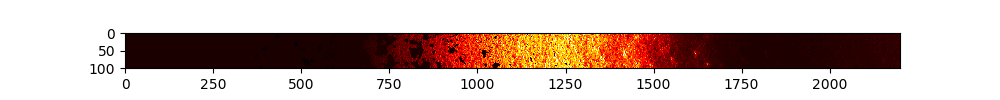

In [8]:
min_val = 0
max_val = 1
fig = plt.figure(figsize=(10,1.))
plt.imshow( LC_train[5500,:,:,0], cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

In [ ]:
plt.figure()
plt.plot( x, contrast )

In [ ]:
LC_train = np.swapaxes( LC_train, 2, 3 )
LC_train *= contrast
LC_train = np.swapaxes( LC_train, 2, 3 )

In [ ]:
LC_train.shape

In [ ]:
LC_train = np.swapaxes( LC_train, 2, 3 )

In [ ]:
min_val = 0
max_val = 1
fig = plt.figure(figsize=(10,1.))
plt.imshow( LC_train[0,:,:,0], cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

In [ ]:
min_val = 0
max_val = 1
fig = plt.figure(figsize=(10,1.))
plt.imshow( LC_train[0,:,:,0], cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

fig = plt.figure(figsize=(10,1.))
plt.imshow( LC_train[0,:,:,0] * contrast, cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

In [ ]:
LC_train[0,:,:,0] * contrast

In [ ]:
min_val = -250
max_val = 50
fig = plt.figure(figsize=(10,1.))
plt.imshow( (DATA)[0], cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

min_val = -250
max_val = 50
fig = plt.figure(figsize=(10,1.))
plt.imshow( (DATA-DATA_avg_1D)[0], cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

min_val = -250
max_val = 50
fig = plt.figure(figsize=(10,1.))
plt.imshow( (DATA-T_avg)[0], cmap=EoR_colour, interpolation=None, vmin=min_val, vmax=max_val )

plt.figure()
plt.plot( DATA_avg_1D )
plt.hlines( T_avg, plt.xlim()[0], plt.xlim()[1] )